In [1]:
#Import Libraries 
import tensorflow as tf 
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd 
from PIL import Image
import glob
import numpy as np

In [2]:
#Load Data
import shutil
data_dir_train = '../input/plant-seedlings-classification/train'
data_dir_test = '../input/plant-seedlings-classification'

In [3]:
#define parameters 
batch_size = 32
img_width = 224
img_height = 224 
epochs = 20

seed = 10
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
#Split data
train_image_data = ImageDataGenerator(
    validation_split = 0.2,
    rescale = 1.0/255.0,
    rotation_range = 30,
    horizontal_flip = True, 
    vertical_flip = True,
    zoom_range=0.4, 
    shear_range = 0.3
)

train_ds = train_image_data.flow_from_directory(
  data_dir_train,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="training")

val_ds = train_image_data.flow_from_directory(
  data_dir_train,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="validation")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [5]:
#Initialise test generator [794 images belonging to 1 class]
test_image_data = ImageDataGenerator(rescale=1./255)
test_ds = test_image_data.flow_from_directory(data_dir_test,
                                              classes=['test'],
                                              target_size=(img_height,img_width),
                                              batch_size = 1,
                                              class_mode ='categorical',
                                              shuffle = False)

Found 794 images belonging to 1 classes.


In [6]:
train_steps = train_ds.samples//batch_size
val_steps = val_ds.samples//batch_size
test_steps = test_ds.samples

In [7]:
#Create Model
model = tf.keras.Sequential([
            tf.keras.applications.resnet_v2.ResNet152V2(input_shape=[224,224, 3], include_top=False, weights='imagenet'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(12, activation='softmax')
])

model.summary()

2021-11-27 04:41:58.019667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 04:41:58.167467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 04:41:58.168587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 04:41:58.170798: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

234561536/234545216 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_______________________________________________________

In [8]:
#SGD
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

#ADAM 
#from tensorflow.keras.optimizers import Adam
#opt = Adam(learning_rate=0.0005, epsilon=0.1)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
#Save model checkpoint
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [10]:
#Train Model
history =model.fit(
                train_ds,
                steps_per_epoch = train_steps,
                validation_data = val_ds, 
                validation_steps = val_steps,
                epochs = epochs,
                callbacks=[model_checkpoint_callback])

2021-11-27 04:42:15.242070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-11-27 04:42:34.219574: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


118/118 [==============================] - 231s 2s/step - loss: 2.3634 - accuracy: 0.2368 - val_loss: 1.8175 - val_accuracy: 0.4300


2021-11-27 04:46:47.815040: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
118/118 [==============================] - 143s 1s/step - loss: 1.5742 - accuracy: 0.4940 - val_loss: 1.1313 - val_accuracy: 0.6358


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/20
118/118 [==============================] - 142s 1s/step - loss: 1.0798 - accuracy: 0.6539 - val_loss: 0.6778 - val_accuracy: 0.7791


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/20
118/118 [==============================] - 142s 1s/step - loss: 0.8266 - accuracy: 0.7364 - val_loss: 0.5447 - val_accuracy: 0.8244


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/20
118/118 [==============================] - 142s 1s/step - loss: 0.6804 - accuracy: 0.7765 - val_loss: 0.4653 - val_accuracy: 0.8610


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/20
118/118 [==============================] - 142s 1s/step - loss: 0.5678 - accuracy: 0.8210 - val_loss: 0.4253 - val_accuracy: 0.8739


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/20
118/118 [==============================] - 142s 1s/step - loss: 0.5175 - accuracy: 0.8364 - val_loss: 0.3641 - val_accuracy: 0.8836


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/20
118/118 [==============================] - 142s 1s/step - loss: 0.4679 - accuracy: 0.8475 - val_loss: 0.3536 - val_accuracy: 0.8772
Epoch 9/20
118/118 [==============================] - 144s 1s/step - loss: 0.3983 - accuracy: 0.8685 - val_loss: 0.3097 - val_accuracy: 0.9084


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/20
118/118 [==============================] - 142s 1s/step - loss: 0.3898 - accuracy: 0.8732 - val_loss: 0.3020 - val_accuracy: 0.9019
Epoch 11/20
118/118 [==============================] - 148s 1s/step - loss: 0.3557 - accuracy: 0.8839 - val_loss: 0.2943 - val_accuracy: 0.9052
Epoch 12/20
118/118 [==============================] - 143s 1s/step - loss: 0.3458 - accuracy: 0.8812 - val_loss: 0.2695 - val_accuracy: 0.9149


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/20
118/118 [==============================] - 143s 1s/step - loss: 0.2992 - accuracy: 0.8979 - val_loss: 0.2946 - val_accuracy: 0.9052
Epoch 14/20
118/118 [==============================] - 143s 1s/step - loss: 0.3060 - accuracy: 0.8929 - val_loss: 0.2457 - val_accuracy: 0.9224


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/20
118/118 [==============================] - 142s 1s/step - loss: 0.2730 - accuracy: 0.9019 - val_loss: 0.3014 - val_accuracy: 0.9149
Epoch 16/20
118/118 [==============================] - 143s 1s/step - loss: 0.2531 - accuracy: 0.9098 - val_loss: 0.2741 - val_accuracy: 0.9203
Epoch 17/20
118/118 [==============================] - 143s 1s/step - loss: 0.2397 - accuracy: 0.9112 - val_loss: 0.2672 - val_accuracy: 0.9289


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/20
118/118 [==============================] - 149s 1s/step - loss: 0.2491 - accuracy: 0.9104 - val_loss: 0.2860 - val_accuracy: 0.9278
Epoch 19/20
118/118 [==============================] - 144s 1s/step - loss: 0.2417 - accuracy: 0.9199 - val_loss: 0.2523 - val_accuracy: 0.9278
Epoch 20/20
118/118 [==============================] - 142s 1s/step - loss: 0.2256 - accuracy: 0.9178 - val_loss: 0.2644 - val_accuracy: 0.9310


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


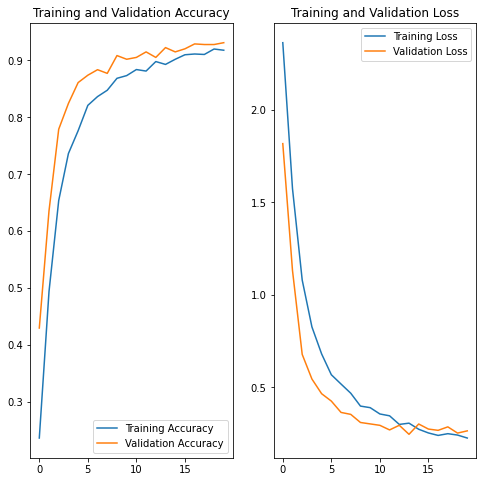

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
model.evaluate_generator(generator=val_ds, steps=val_steps)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.23140715062618256, 0.923491358757019]

In [13]:
test_ds.reset() #maintain test order
test_predictions = model.predict(test_ds, test_ds.samples, verbose=1 )

794/794 [==============================] - 38s 43ms/step


In [14]:
predicted_plant_type = np.argmax(test_predictions, axis=1)

In [15]:
predicted_plant_type = np.argmax(test_predictions, axis=1)

labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_plant_type]

test_pred = []
filenames=test_ds.filenames
for name in range(len(filenames)):
   test_pred.append(filenames[name].split('/')[1])

results=pd.DataFrame({"file":test_pred,
                      "species":predictions})
results.to_csv("submission.csv",index=False)